In [1]:
%matplotlib inline

import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from torch.utils.data import DataLoader
import torch
from typing import List, Literal
from pathlib import Path
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, fbeta_score
import re

from predpy.dataset import MultiTimeSeriesDataset
from predpy.experimentator import (
    DatasetParams, ModelParams,
    Experimentator, load_experimentator, load_last_experimentator)
from predpy.plotter import plot_anomalies, get_ids_ranges, get_cls_ids_ranges
from anomaly_detection import (
    AnomalyDetector, fit_run_detection, exp_fit_run_detection,
    get_dataset, get_dataset_names, load_anom_scores)

from notebook_utils.modeling import (
    predict, get_rec_fbeta_score_conf_mat,
    get_a_scores, get_model_recon_one_per_point,
    adjust_point_cls_with_window,
    th_ws_experiment, stats_experiment
)
from notebook_utils.plotting import (
    plot_scores, plot_kde, plot_dataset, plot_scores_and_bands
)
from notebook_utils.save_load import (
    save_th_exp, load_th_exp
)
from notebook_utils.ts_stats import (
    get_bollinger, get_std, get_diff
)


os.chdir('/home/stachu/Projects/Anomaly_detection/TSAD')
sns.set_style()

# Data and model loading

In [2]:
exp = load_experimentator('./saved_experiments/2022-05-30_22:57:20.pkl')
model_id = 0
exp.models_params

name_                                cls_  \
0  ConvMVR_ws200_nk10_ks3_es50  <class 'models.ideas.mvr.ConvMVR'>   
1  ConvMVR_ws200_nk10_ks3_es50  <class 'models.ideas.mvr.ConvMVR'>   
2  ConvMVR_ws200_nk10_ks3_es50  <class 'models.ideas.mvr.ConvMVR'>   

                                         init_params  \
0  {'window_size': 200, 'c_in': 38, 'n_kernels': ...   
1  {'window_size': 200, 'c_in': 38, 'n_kernels': ...   
2  {'window_size': 200, 'c_in': 38, 'n_kernels': ...   

                              WrapperCls wrapper_kwargs  \
0  <class 'models.ideas.mvr.MVRWrapper'>             {}   
1  <class 'models.ideas.mvr.MVRWrapper'>             {}   
2  <class 'models.ideas.mvr.MVRWrapper'>             {}   

                                     learning_params  
0  {'lr': 0.0001, 'criterion': MSELoss(), 'Optimi...  
1  {'lr': 0.0001, 'criterion': MSELoss(), 'Optimi...  
2  {'lr': 0.0001, 'criterion': MSELoss(), 'Optimi...

In [3]:
m_name = 'ConvMVR_ws200_nk10_ks3_es50'
topic, colleciton_name, ds_name = 'Industry', 'ServerMachineDataset', 'machine-1-1'
exp_date = exp.exp_date
model = exp.load_pl_model(model_id, f'checkpoints/machine-1-1/{m_name}')
window_size = model.model.params['window_size']
scores_dirpath = f'notebook_a_scores/{colleciton_name}/{ds_name}/{m_name}/{exp_date}/'

In [4]:
train_ds = get_dataset(
    f'data/{topic}/{colleciton_name}/train/{ds_name}.csv',
    window_size=window_size)
test_ds = get_dataset(
    f'data/{topic}/{colleciton_name}/test/{ds_name}.csv',
    window_size=window_size)

train_dl = DataLoader(train_ds, batch_size=500)
test_dl = DataLoader(test_ds, batch_size=500)
test_index = test_ds.sequences[0].index

test_cls_path = f'saved_scores_preds/{colleciton_name}/{ds_name}/record_classes/{window_size}.csv'
test_cls = pd.read_csv(
    test_cls_path, header=None)\
    .iloc[:, 0].to_numpy()
test_point_cls_path = f'data/{topic}/{colleciton_name}/test_label/{ds_name}.csv'
test_point_cls = pd.read_csv(
    test_point_cls_path, header=None)\
    .iloc[:, 0].to_numpy()

n_features = train_ds.sequences[0].shape[1]

## Load scores

In [5]:
# # x_hat1_l2 = np.load(scores_dirpath + 'x_hat1_l2.npy', allow_pickle=True)
# # x_hat2_l2 = np.load(scores_dirpath + 'x_hat2_l2.npy', allow_pickle=True)

# # s_x_hat1_l2 = np.load(scores_dirpath + 's_x_hat1_l2.npy', allow_pickle=True)
# # s_x_hat2_l2 = np.load(scores_dirpath + 's_x_hat2_l2.npy', allow_pickle=True)

x_hat1 = np.load(scores_dirpath + 'x_hat1.npy', allow_pickle=True)
x_hat1_err_points = np.load(scores_dirpath + 'x_hat1_err_points.npy', allow_pickle=True)
x_hat1_err_points_st = np.load(scores_dirpath + 'x_hat1_err_points_st.npy', allow_pickle=True)

# Dataset plotting

Plotting "machine-1-1" dataset.  
Blue is training dataset, orange is test dataset.  
Anomalies are red regions, they are present only in test dataset.  
Not all features express anomalies.  

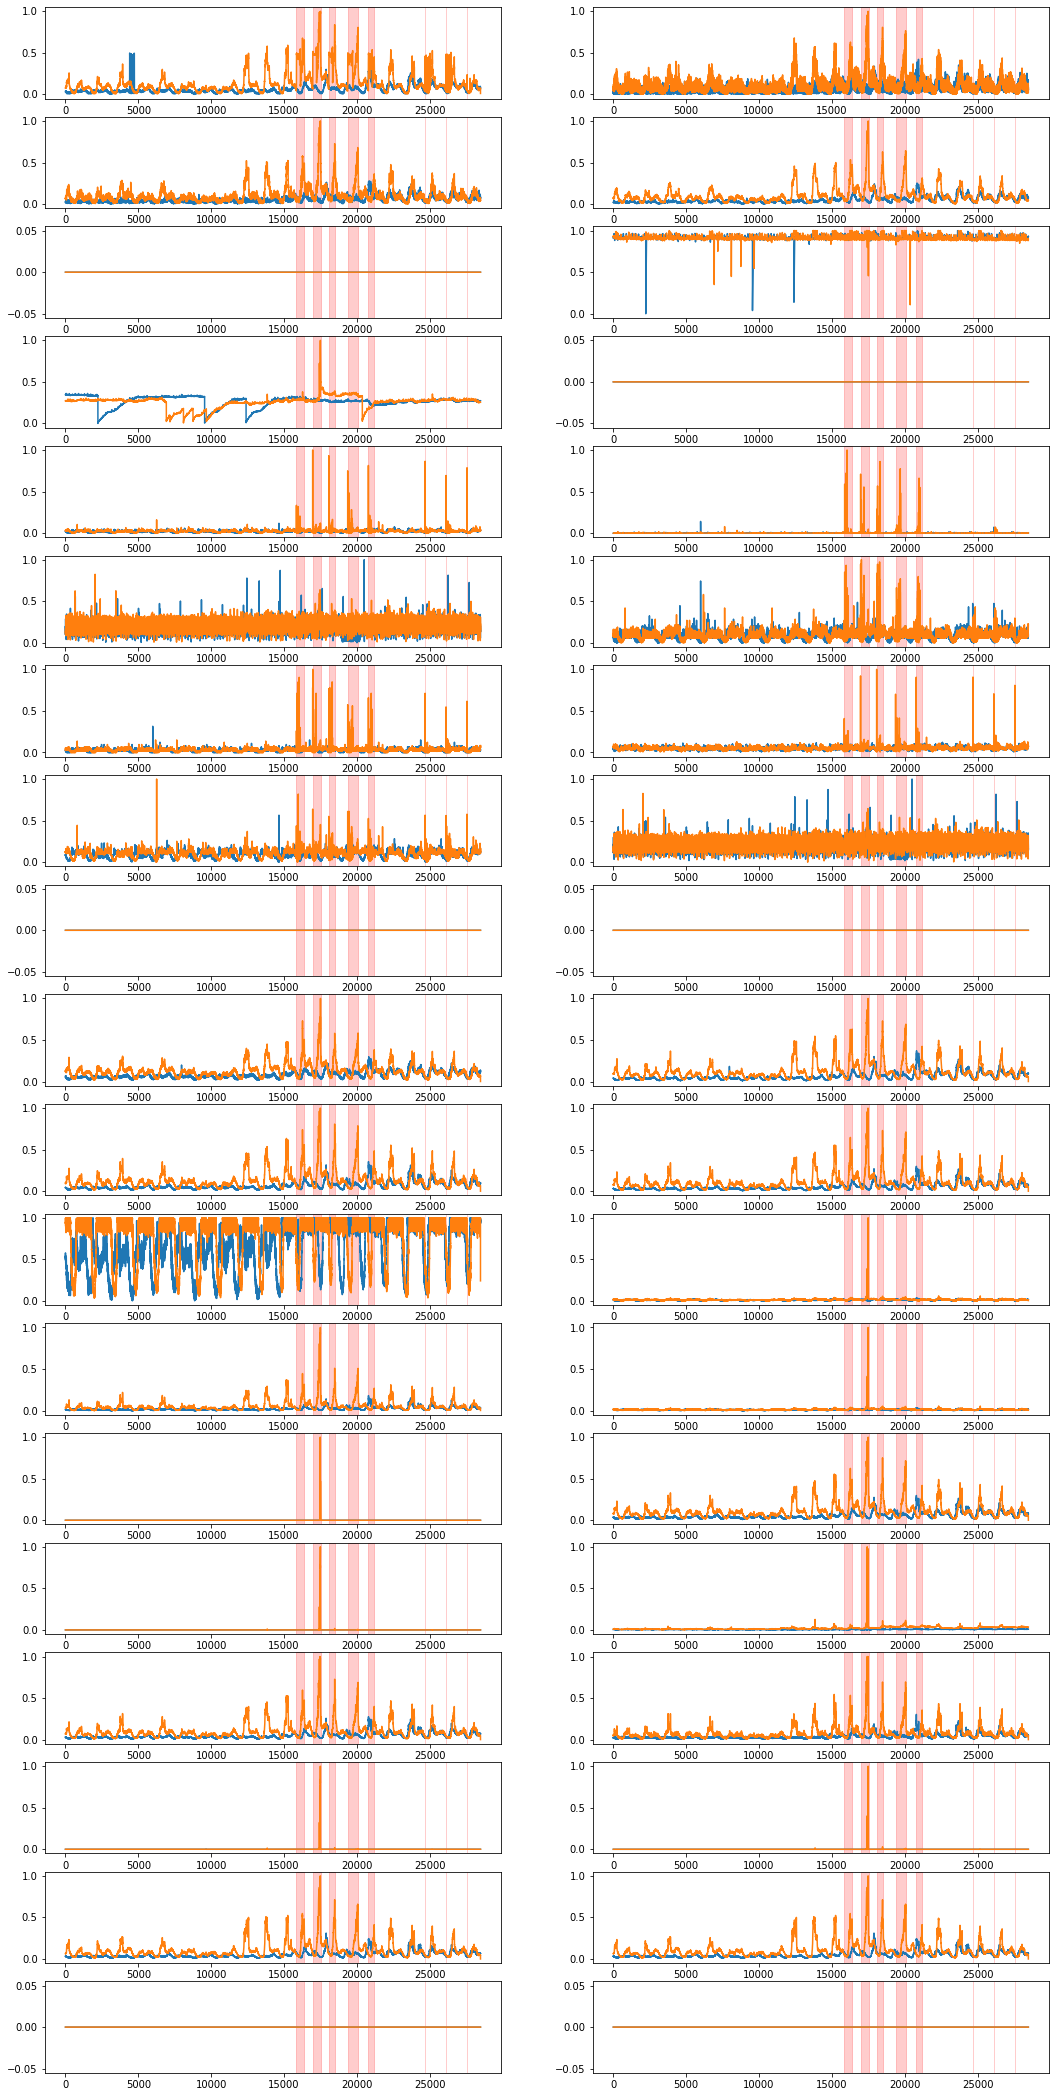

In [29]:
anoms_vrects = [
    (15849, 16368), (16963, 17517), (18071, 18528), (19367, 20088),
    (20786, 21195), (24679, 24682), (26114, 26116), (27554, 27556)]

# fig, axs = plt.subplots(19, 2, figsize=(16, 76))
# for i in range(38):
#     col = i % 2
#     row = int(i/2)
#     axs[row, col].plot(train_dl.dataset.sequences[0].to_numpy()[:, i], label='train')
#     axs[row, col].plot(test_dl.dataset.sequences[0].to_numpy()[:, i], label='test')

#     for start, end in anoms_vrect:
#         axs[row, col].axvspan(start, end, alpha=0.2, color='red')
plot_dataset(
    train_ds=train_dl.dataset.sequences[0].to_numpy(),
    test_ds=test_dl.dataset.sequences[0].to_numpy(),
    anoms_vrects=anoms_vrects);


# Collecting and storing anomaly scores

In [6]:
# test_as, pred_cls = load_anom_scores(
#     f'saved_scores_preds/ServerMachineDataset/machine-1-1/{m_name}/anom_scores.csv')

## Training scalers
Scalers are trained separate for x_hat1 and x_hat2 on part of training dataset for testing model.

In [8]:
# x_hat1_st = get_model_recon_one_per_point(
#     model=model, dataloader=DataLoader(train_ds, batch_size=1), ws=window_size
# )
# # res = get_model_recon_one_per_point(
# #     model=model, dataloader=DataLoader(train_ds, batch_size=1), ws=window_size)
# # x_hat1_st, x_hat2_st = zip(*res)
# # x_hat1_st = torch.concat(x_hat1_st, dim=1).view(-1, n_features).numpy()
# # x_hat2_st = torch.concat(x_hat2_st, dim=1).view(-1, n_features).numpy()
# x_all_st = train_ds.sequences[0].to_numpy()
# x_hat1_err_points_st = np.abs(x_hat1_st - x_all_st)

100%|██████████| 28279/28279 [00:26<00:00, 1079.41it/s]


In [8]:
# x_hat1_l2_st = torch.max(x_hat1_st - x_all_st, dim=1)[0].numpy()
# x_hat2_l2_st = torch.max(x_hat2_st - x_all_st, dim=1)[0].numpy()
# scaler_1 = MinMaxScaler(feature_range=(0, 1))
# scaler_2 = MinMaxScaler(feature_range=(0, 1))
# s_x_hat1_l2_st = scaler_1.fit_transform(x_hat1_l2_st)
# s_x_hat2_l2_st = scaler_2.fit_transform(x_hat2_l2_st)

In [9]:
# len_, ws = x_hat1_st.shape[0:2]
# len_ += ws
# x_hat1_err_points_st = [
#     x_hat1_st[i*ws] - x_all_st[i*ws]
#     for i in range(int(len_/ws))
# ]
# rest = len_ - int(len_/ws) * ws
# x_hat1_err_points_st += [x_hat1_st[-1, -rest:] - x_all_st[-1, -rest:]]
# x_hat1_err_points_st = np.concatenate(x_hat1_err_points_st)
# x_hat1_err_points_st = np.abs(x_hat1_err_points_st)
# x_hat1_err_points_st.shape

(28478, 38)

## Computing anomaly score
Anomaly scores are made on test dataset.

In [6]:
# # res = get_model_recon_one_per_point(
# #     model=model, dataloader=DataLoader(train_ds, batch_size=1), ws=window_size)
# # x_hat1, x_hat2 = zip(*res)
# # x_hat1 = torch.concat(x_hat1, dim=1).view(-1, n_features).numpy()
# # x_hat2 = torch.concat(x_hat2, dim=1).view(-1, n_features).numpy()
# # x_all = test_ds.sequences[0].to_numpy()
# x_hat1 = get_model_recon_one_per_point(
#     model=model, dataloader=DataLoader(test_ds, batch_size=1), ws=window_size
# )
# x_all = test_ds.sequences[0].to_numpy()
# x_hat1_err_points = np.abs(x_hat1 - x_all)

100%|██████████| 28279/28279 [00:26<00:00, 1048.39it/s]


## Evaluating visually scalers

### Train ds scores

In [21]:
# plot_scores(s_x_hat1_l2_st);

### Test ds scores

In [22]:
# plot_scores(s_x_hat2_l2_st);

## Collecting points rec err

## Scaling scores

In [99]:
# s_x_hat1_l2 = scaler_1.transform(x_hat1_l2)
# s_x_hat2_l2 = scaler_2.transform(x_hat2_l2)

## Saving scores

In [8]:
# scores_dirpath = f'notebook_a_scores/{colleciton_name}/{ds_name}/{m_name}/{exp_date}/'
# os.makedirs(scores_dirpath, exist_ok=True)

# # x_hat1_l2.dump(scores_dirpath + 'x_hat1_l2.npy')
# # x_hat2_l2.dump(scores_dirpath + 'x_hat2_l2.npy')

# # s_x_hat1_l2.dump(scores_dirpath + 's_x_hat1_l2.npy')
# # s_x_hat2_l2.dump(scores_dirpath + 's_x_hat2_l2.npy')
# # x_hat1_l2.dump(scores_dirpath + 'x_hat1_max.npy')
# # x_hat2_l2.dump(scores_dirpath + 'x_hat2_max.npy')

# # s_x_hat1_l2.dump(scores_dirpath + 's_x_hat1_max.npy')
# # s_x_hat2_l2.dump(scores_dirpath + 's_x_hat2_max.npy')

# x_hat1.dump(scores_dirpath + 'x_hat1.npy')
# x_hat1_err_points.dump(scores_dirpath + 'x_hat1_err_points.npy')
# x_hat1_err_points_st.dump(scores_dirpath + 'x_hat1_err_points_st.npy')

## Comparing scopes
Calculating difference in train dataset for testing (last 10% of points) and test dataset.

In [84]:
# tmp = s_x_hat1_l2_st
# start = int(tmp.shape[0] * 0.9)
# train_scopes = []
# for x_min, x_max in zip(tmp.min(axis=0).tolist(), tmp.max(axis=0).tolist()):
#     train_scopes += [x_max - x_min]
# train_scopes = np.array(train_scopes)

In [85]:
# tmp = x_hat1_l2
# test_scopes = []
# for x_min, x_max in zip(tmp[:5000].min(axis=0).tolist(), tmp[:5000].max(axis=0).tolist()):
#     test_scopes += [x_max - x_min]
# test_scopes = np.array(test_scopes)

Due to different values scopes in training scaler dataset and test anomaly 

In [86]:
# scopes_diffs = train_scopes - test_scopes
# scopes_diffs[np.argwhere(scopes_diffs)]
# np.round(scopes_diffs, 2)

array([-8.370e+00,  2.200e-01,  1.900e-01,  5.400e-01,  0.000e+00,
       -2.029e+01, -3.570e+00,  0.000e+00, -5.700e-01,  7.600e-01,
       -1.300e+00, -2.900e-01, -5.500e-01, -1.270e+00, -4.000e-01,
       -1.230e+00,  0.000e+00,  0.000e+00,  4.600e-01,  5.800e-01,
        1.000e-01,  5.500e-01,  5.000e-02, -3.700e-01,  4.700e-01,
       -2.000e-02,  0.000e+00,  5.300e-01,  0.000e+00,  2.400e-01,
        6.000e-01,  5.500e-01, -9.300e-01,  8.700e-01,  4.600e-01,
        4.100e-01,  0.000e+00,  0.000e+00])

# Plotting scores

## KDE over train and test datasets

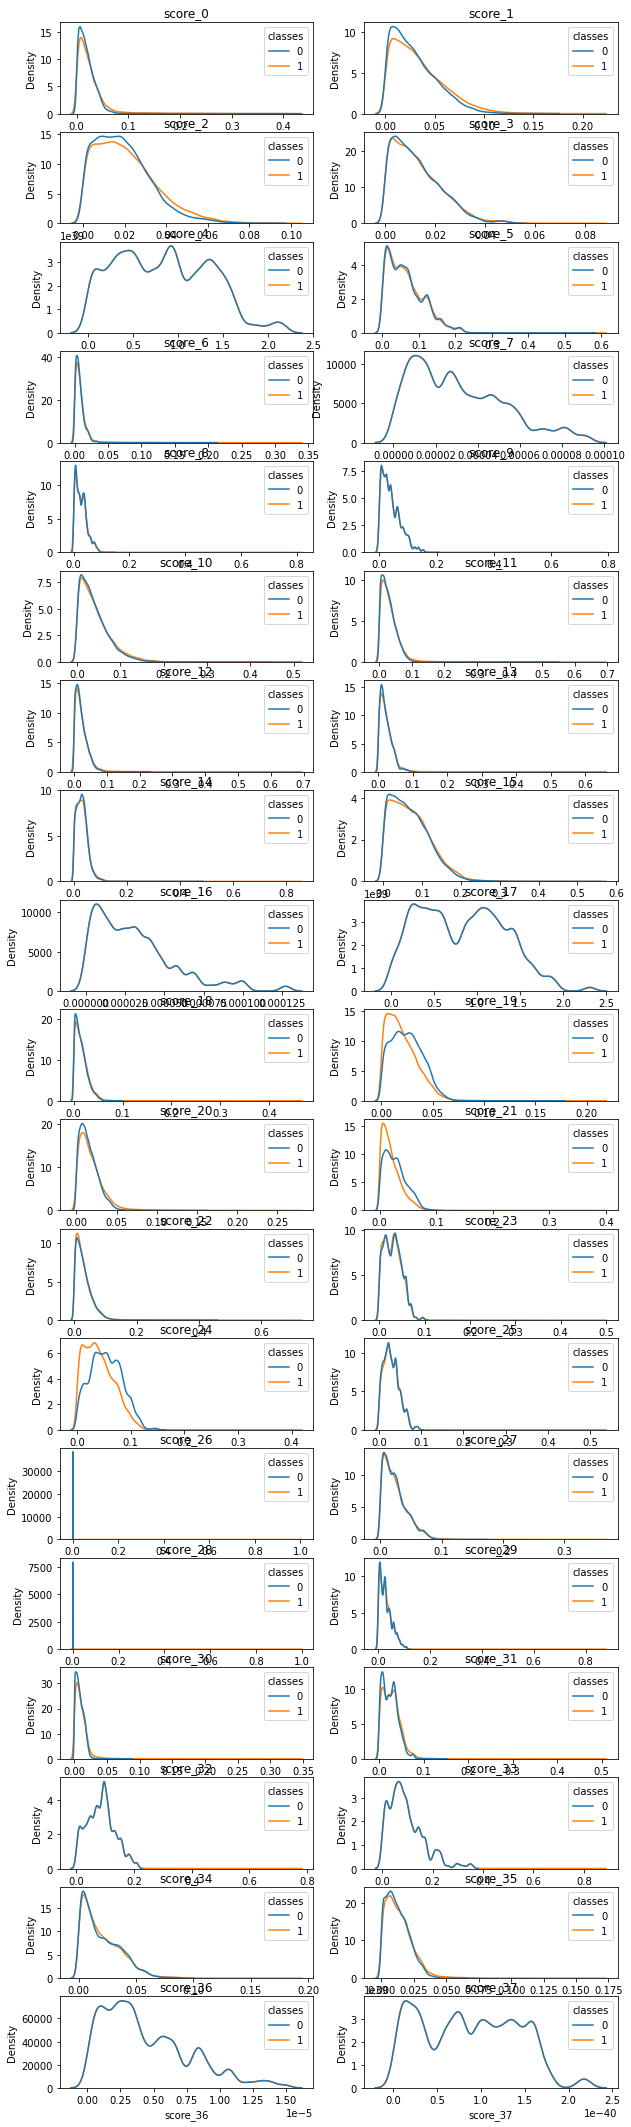

In [17]:
plot_kde(x_hat1_err_points_st, scores2=x_hat1_err_points);

## Rec err for points

Plotting most anomalious features reconstruction

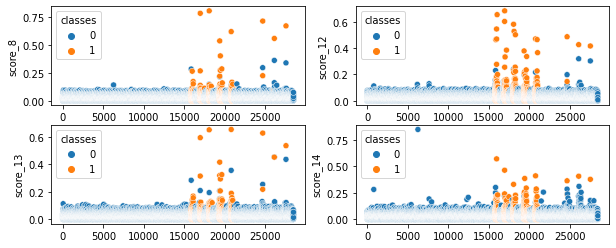

In [6]:
cols = [col - 1 for col in [9,13,14,15]]
plot_scores(x_hat1_err_points, classes=test_point_cls, features_cols=cols);

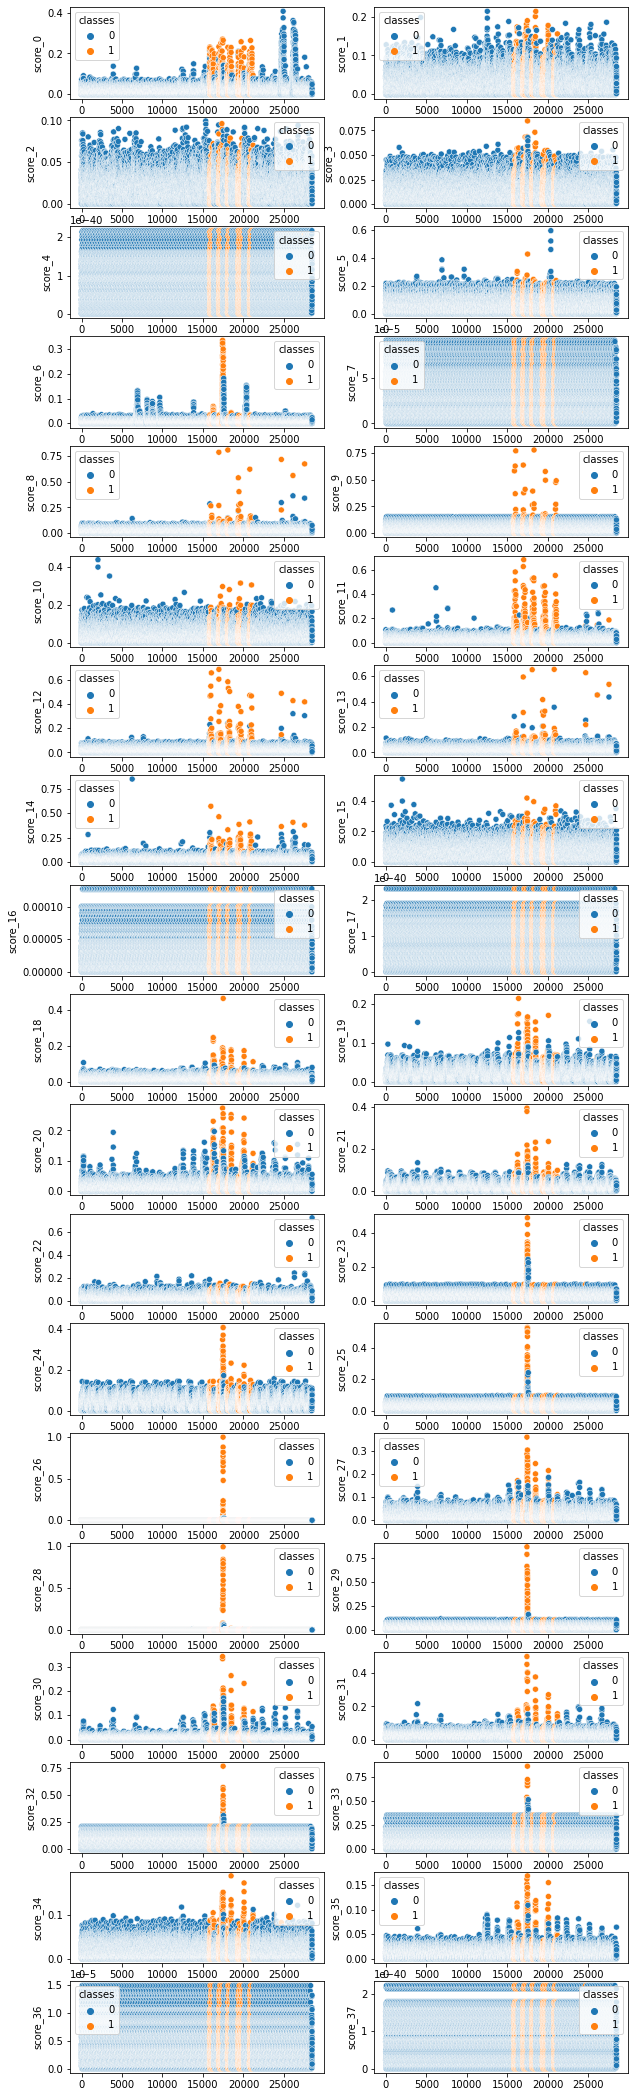

In [19]:
plot_scores(x_hat1_err_points, classes=test_point_cls);

## Decoder reconstruction error

### Scaled on test ds

In [10]:
# tmp_scaler = StandardScaler()
# tmp_s_x_hat1_l2 = tmp_scaler.fit_transform(x_hat1_l2)

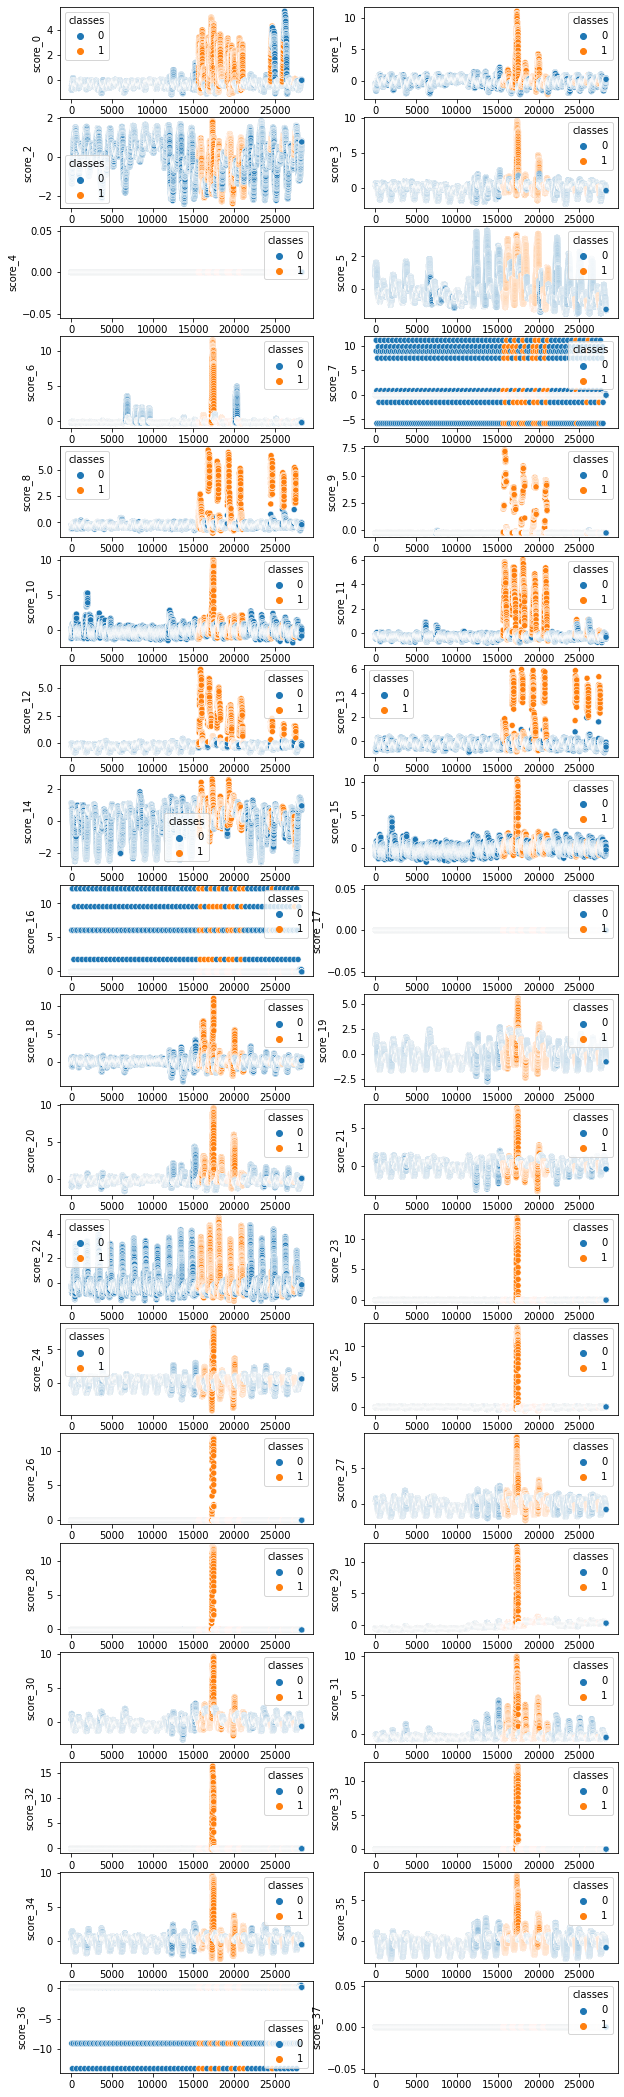

In [11]:
# plot_scores(tmp_s_x_hat1_l2, classes=test_cls);

### Scaled on first 5000 test points

In [16]:
# tmp2_scaler = StandardScaler().fit(x_hat1_l2[:5000, :])
# tmp2_s_x_hat1_l2 = tmp2_scaler.transform(x_hat1_l2)

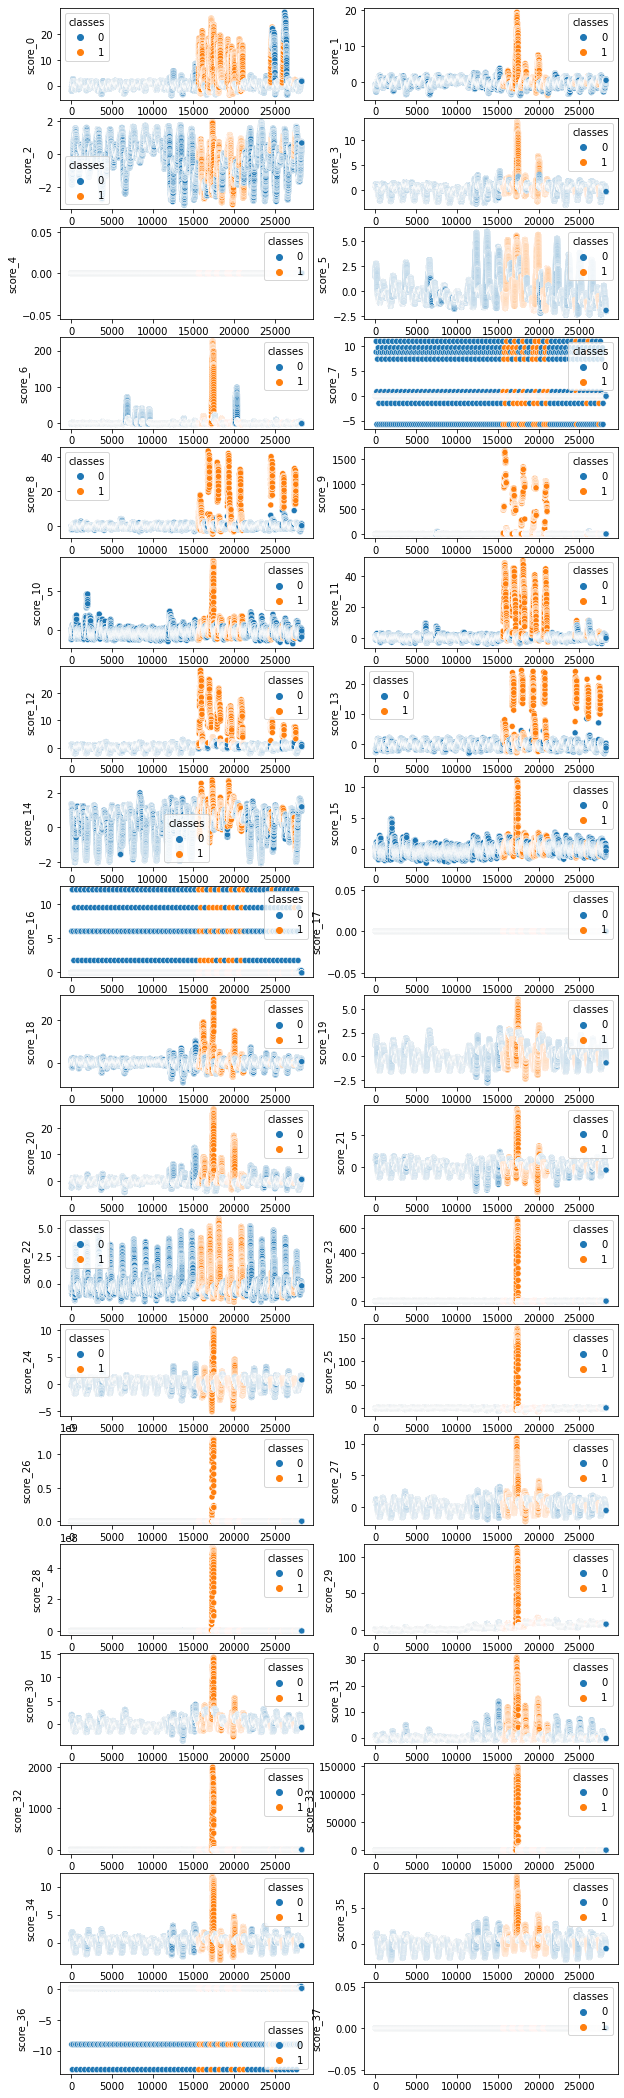

In [17]:
# plot_scores(tmp2_s_x_hat1_l2, classes=test_cls);

### Not scaled

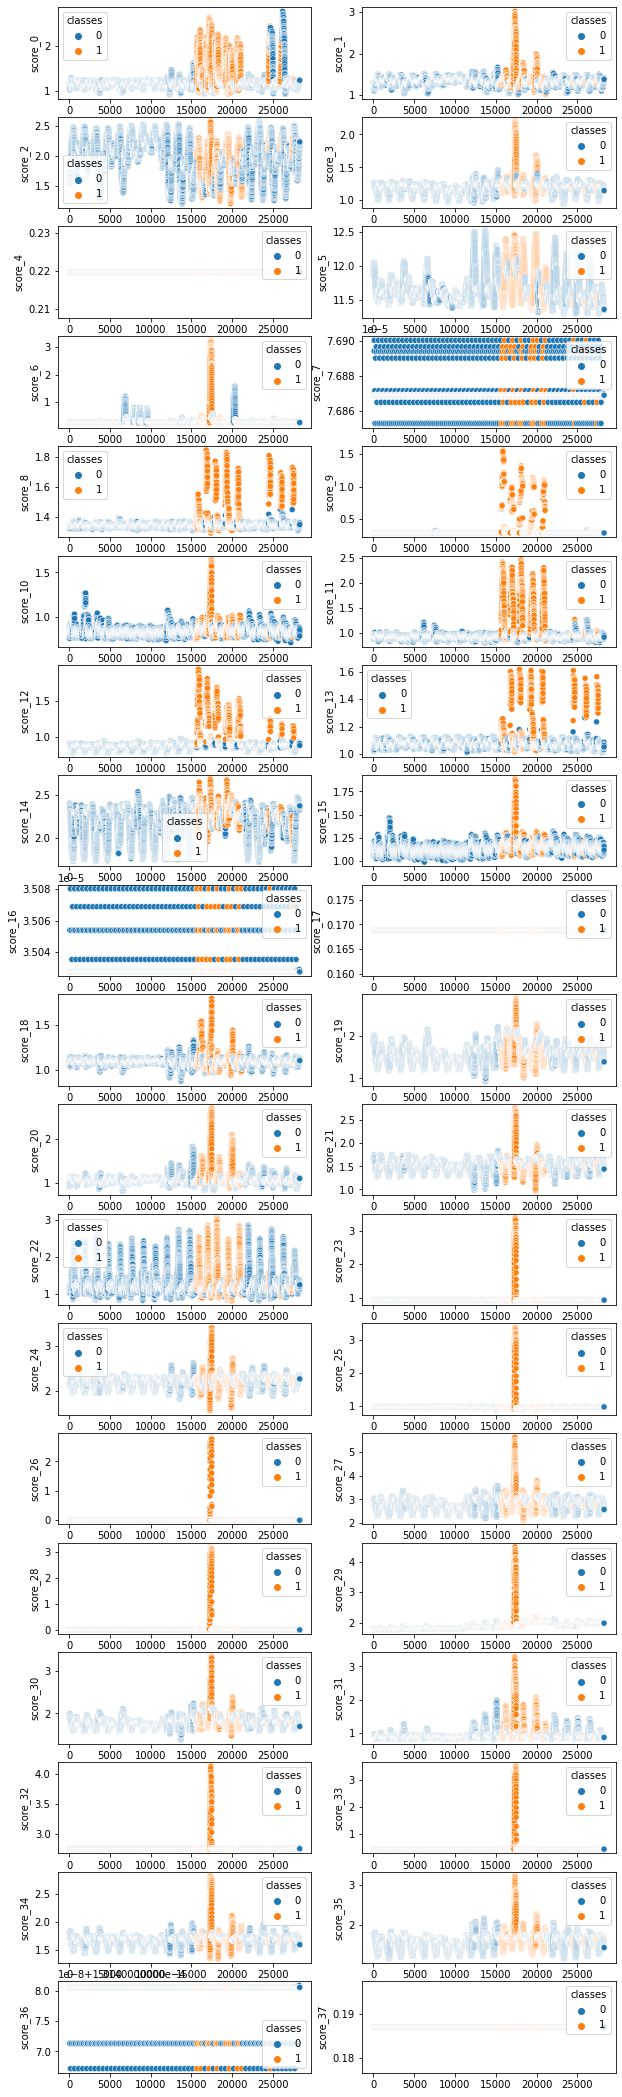

In [8]:
# fig = plot_scores(x_hat1_l2, classes=test_cls)

### Scaled correctly
This scaling use scalers trained on train dataset reconstruction error.  

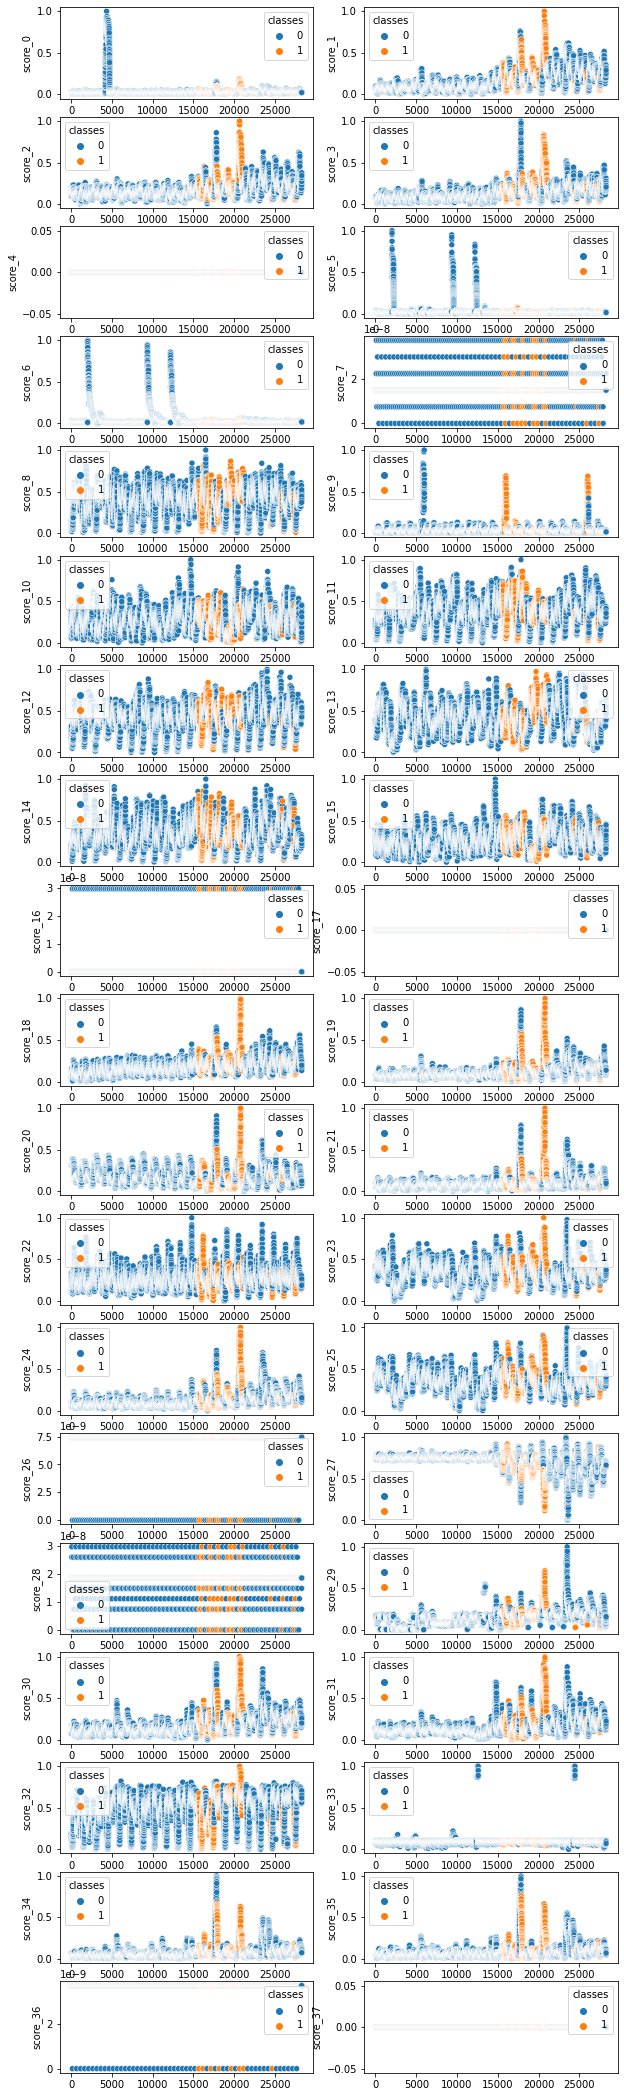

In [92]:
# fig = plot_scores(s_x_hat1_l2, classes=test_cls[1:])

## Redecoder scaled reconstruction error

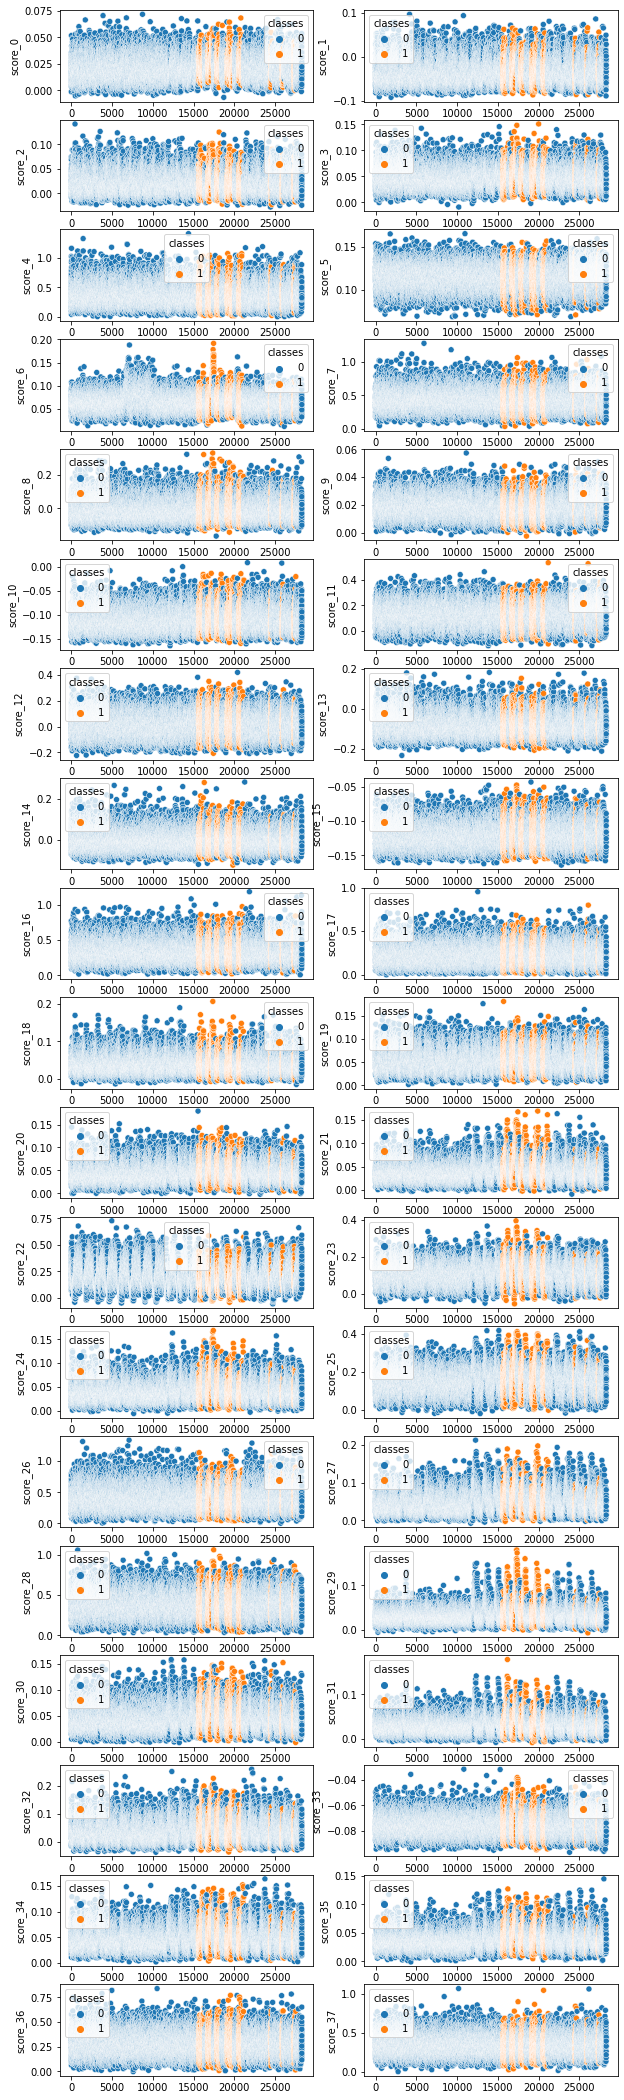

In [112]:
# fig = plot_scores(s_x_hat2_l2, classes=test_cls)

# Finding best ws and th
ws - window size  
th - threshold  
Optimizing beta score.  

## Loading computed scores

In [12]:
th_df = load_th_exp(scores_dirpath + 'th_ws_exp.csv')

## Computing and comparing scores

In [20]:
betas = [0.5, 1]
wss = [200]  # np.arange(100, 501, 100)
ths = np.linspace(0.25, 1.25, 50)
th_df = th_ws_experiment(
    series_index=test_index, point_scores=x_hat1_err_points,
    point_cls=test_point_cls, t_max=500,
    ths=ths, wss=wss, betas=betas)

  0%|          | 0/1 [00:37<?, ?it/s]


KeyboardInterrupt: 

Saving scores

In [36]:
save_th_exp(th_df, scores_dirpath + 'th_ws_exp.csv')

Best f1-score for model window size

In [8]:
th_df[th_df['ws'] == window_size].sort_values('f1-score', ascending=False).head()

ws        th  f0.5-score  f1-score     tn   fp    fn   tp  \
0  200  0.250000    0.185776  0.111975  21802  799  5482  396   
1  200  0.270408    0.168412  0.095864  21964  637  5550  328   
2  200  0.290816    0.153846  0.086123  21990  611  5586  292   
3  200  0.311224    0.124418  0.062965  22234  367  5675  203   
4  200  0.331633    0.104918  0.050008  22357  244  5721  157   

                                       preds_rec_cls  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

Best f0.5-score for model window size

In [13]:
th_df[th_df['ws'] == window_size].sort_values('f0.5-score', ascending=False).head()

f0.5-score  f1-score   ws        th     tn    fp    fn    tp
65    0.803443  0.770221  200  0.556122  21698   887  1647  4247
61    0.789919  0.802445  200  0.474490  21229  1356  1036  4858
60    0.789816  0.802378  200  0.454082  21228  1357  1036  4858
63    0.787871  0.791926  200  0.515306  21297  1288  1186  4708
64    0.787809  0.791824  200  0.535714  21297  1288  1187  4707

Best f1-score for every window size

In [12]:
th_df.loc[th_df.groupby(['ws'])['f1-score'].idxmax()]

f0.5-score  f1-score   ws        th     tn    fp    fn    tp
9      0.774770  0.757012  100  0.433673  23338   847  1163  3131
61     0.789919  0.802445  200  0.474490  21229  1356  1036  4858
110    0.820999  0.846119  300  0.454082  19462  1601   804  6612
165    0.861993  0.864622  400  0.556122  18763  1202  1115  7399
215    0.867261  0.883328  500  0.556122  17702  1424   828  8525

Best f0.5-score for every window size

In [11]:
th_df.loc[th_df.groupby(['ws'])['f0.5-score'].idxmax()]

f0.5-score  f1-score   ws        th     tn    fp    fn    tp
9      0.774770  0.757012  100  0.433673  23338   847  1163  3131
65     0.803443  0.770221  200  0.556122  21698   887  1647  4247
115    0.847983  0.834026  300  0.556122  20063  1000  1396  6020
165    0.861993  0.864622  400  0.556122  18763  1202  1115  7399
215    0.867261  0.883328  500  0.556122  17702  1424   828  8525

# Plotting with best th

In [1]:
# pred_cls = predict(x_hat1_err_points, 0.43, window_size)
# true_cls = adjust_point_cls_with_window(test_point_cls, window_size)
# pred_anom_intervals = get_ids_ranges(np.where(pred_cls == 1)[0])
# true_anom_intervals = get_ids_ranges(np.where(true_cls == 1)[0])
# plot_anomalies(
#     time_series=test_ds.sequences[0], predictions=pd.DataFrame(x_hat1),
#     pred_anomalies_intervals=pred_anom_intervals, true_anomalies_intervals=true_anom_intervals,
#     is_ae=False)

# Searching for descriptive statistics

## Moving std diff

### Loading scores

In [36]:
# bounds = [
#     get_diff(get_bollinger(x_hat1_err_points, ws, m))
#     for ws, m in [(100, 30), (200, 30), (300, 30), (400, 30)]
# ]
# ws_list = [100, 200, 300, 400]
ws_list = [500, 600, 700, 800, 900, 1000]
bounds = [
    get_diff(get_std(x_hat1_err_points, ws))
    for ws in ws_list
]

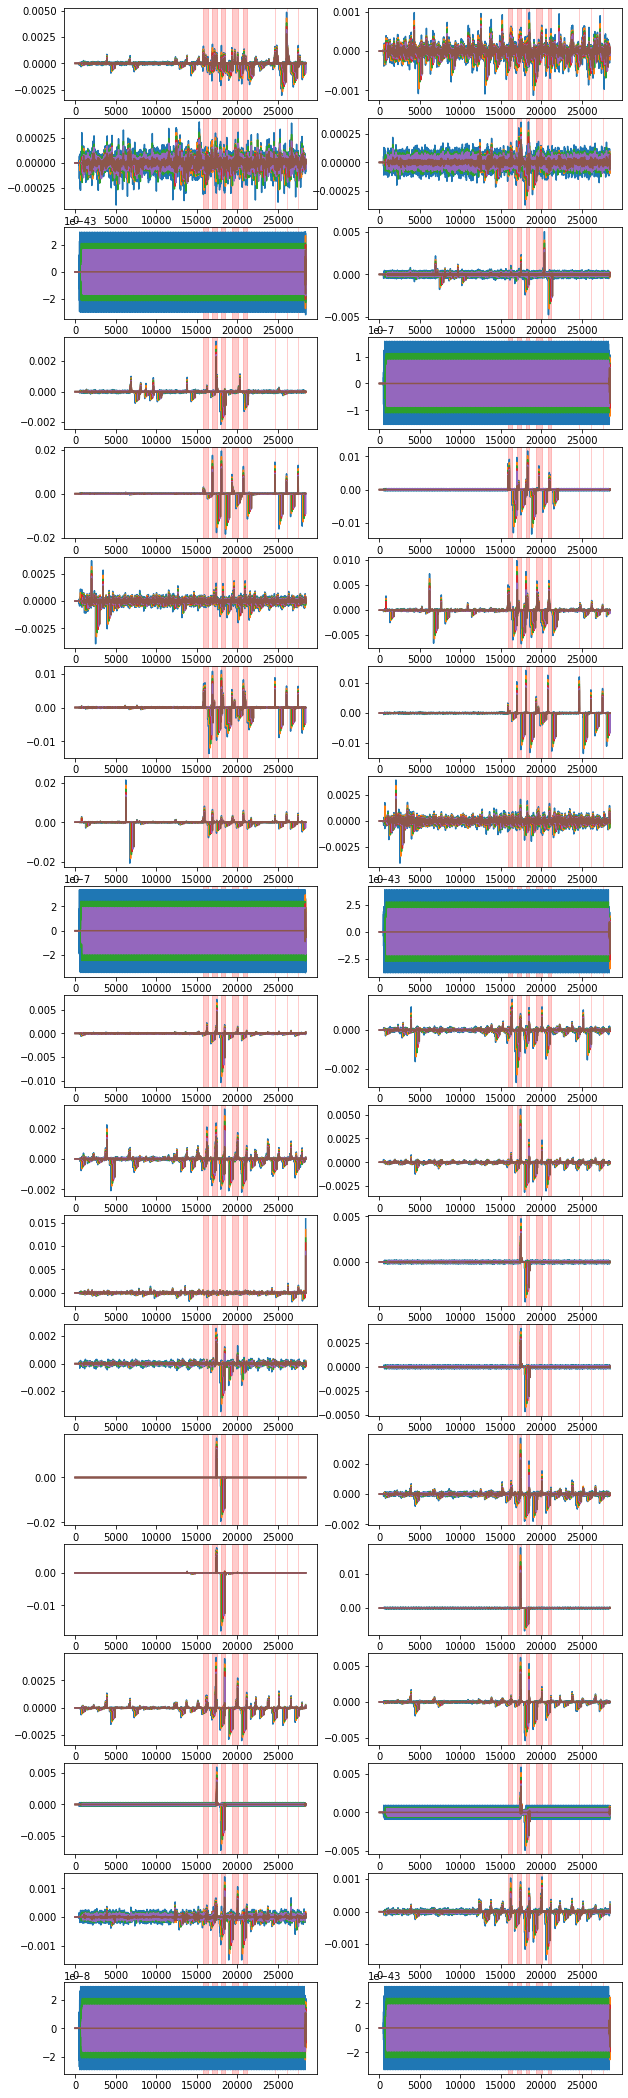

In [37]:
plot_dataset(
    {b.name: b for b in bounds},
    get_ids_ranges(np.where(test_point_cls == 1)[0]),
    # features_cols=[0, 1, 2, 3, 4, 5, 6, 7], figsize=(16, 7),
    # min_id=24600, max_id=24750
);

### Computing and comparing scores

In [72]:
import numpy as np
import pandas as pd
from typing import Dict, List, Literal, Tuple
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, fbeta_score
from collections import defaultdict
import torch
from torch.utils.data import DataLoader
import scipy

from predpy.wrapper import Reconstructor


nd = scipy.stats.norm(loc=0, scale=1)
# pos_in_distribution = nd.ppf(0.95)
pos_in_distribution = 1.5
default_wdd_w_f = nd.pdf(pos_in_distribution)
default_wdd_ma_f = nd.pdf(pos_in_distribution)


def get_a_scores(model, dataloader):
    a_scores = []
    for batch in tqdm(dataloader):
        x = batch['sequence']
        a_score = model.anomaly_score(
            x, scale=False)
        a_scores += [a_score]
    return a_scores


def get_model_recon_one_per_point(
    model: Reconstructor, dataloader: DataLoader, ws: int
) -> List:
    """Batch size must equal 1"""
    recon = []
    len_ = dataloader.dataset.sequences[0].shape[0]
    last_n = len_ % ws
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            if i % ws == 0:
                x = batch['sequence']
                res = model.predict(x)
                recon += [res[0]]
            if i == len(dataloader) - 1 and last_n > 0:
                x = batch['sequence']
                res = model.predict(x)
                recon += [res[0, -last_n:]]
    recon = torch.concat(recon, dim=0).numpy()
    return recon


def predict(
    point_scores: np.ndarray, th: float, ws: int,
    return_point_cls: bool = True
) -> np.ndarray:
    pred_point_cls = np.zeros(len(point_scores))
    p = np.where(np.any(point_scores > th, axis=1))[0]
    pred_point_cls[p] = 1

    if return_point_cls:
        return pred_point_cls
    pred_rec_cls = adjust_point_cls_with_window(
        pred_point_cls, ws, return_point_cls=False)
    return pred_rec_cls


def adjust_point_cls_with_window(
    point_cls: np.ndarray, ws: int,
    return_point_cls: bool = True
):
    """Translating point classes to record classes, then
    if "return_point_cls" is True, projecting classes back on points.

    Any record consisting anomaly point
    is treated as all points in sequence
    are anomalies."""
    s = pd.Series(point_cls)
    res = s.rolling(2*ws - 1, center=True).max()
    res[:ws] = res[:ws].index.to_series().apply(
        lambda idx: s[0:idx + ws].max()
    )
    if return_point_cls:
        res[-ws:] = res[-ws:].index.to_series().apply(
            lambda idx: s[idx - ws:].max()
        )
    else:
        res = res.dropna().iloc[1:]

    return res.to_numpy()


def get_rec_fbeta_score_conf_mat(
    point_scores: np.ndarray, point_cls: np.ndarray,
    th: float, ws: int, beta: float = 1
) -> Tuple[float, List[List[int]]]:
    pred_cls = predict(
        point_scores=point_scores, th=th, ws=ws)
    true_cls = pd.Series(point_cls).rolling(
        ws).max().dropna().to_numpy()

    f1_score = fbeta_score(true_cls, pred_cls, beta=beta)
    cm = confusion_matrix(true_cls, pred_cls)
    return f1_score, cm


def th_ws_experiment(
    series_index: pd.Index, point_scores: np.ndarray,
    point_cls: List[Literal[0, 1]], ths: List[float],
    wss: List[int], t_max: int = None, w_f: float = None,
    ma_f: float = None, betas: List[float] = [1.0]
) -> pd.DataFrame:
    if type(betas) in [int, float]:
        betas = [betas]
    threshold_stats = defaultdict(lambda: [])

    for ws in tqdm(wss):
        true_cls = adjust_point_cls_with_window(
            point_cls, ws, return_point_cls=False)
        for th in ths:
            exp_step(
                threshold_stats=threshold_stats, series_index=series_index,
                point_scores=point_scores, true_cls=true_cls,
                th=th, ws=ws, t_max=t_max, w_f=w_f, ma_f=ma_f,
                betas=betas
            )
    return pd.DataFrame(threshold_stats)


def stats_experiment(
    series_index: pd.Index, point_scores_list: List[np.ndarray],
    point_cls: List[Literal[0, 1]], ths_list: List[List[float]],
    ws_list: List[int], t_max: int = None, w_f: float = None,
    ma_f: float = None, betas: List[float] = [1.0],
) -> pd.DataFrame:
    if type(betas) in [int, float]:
        betas = [betas]
    threshold_stats = defaultdict(lambda: [])
    assert len(point_scores_list) == len(ths_list) == len(ws_list),\
        'Length of "point_scores" (%d), "ths" (%d), "wss" (%d) not same'\
        % (len(point_scores_list), len(ths_list), len(ws_list))

    n_stats = len(point_scores_list)
    for i in tqdm(range(n_stats)):
        point_scores = point_scores_list[i]
        ths = ths_list[i]
        ws = ws_list[i]
        true_cls = adjust_point_cls_with_window(
            point_cls, ws, return_point_cls=False)

        for th in ths:
            exp_step(
                threshold_stats=threshold_stats, series_index=series_index,
                point_scores=point_scores, true_cls=true_cls,
                th=th, ws=ws, t_max=t_max, w_f=w_f, ma_f=ma_f,
                betas=betas
            )
    return pd.DataFrame(threshold_stats)


def exp_step(
    threshold_stats: Dict, series_index: pd.Index,
    point_scores: np.ndarray, true_cls: np.ndarray,
    th: float, ws: int, t_max: int = None,
    w_f: float = None, ma_f: float = None,
    betas: List[float] = [1.0]
):
    pred_cls = predict(
        point_scores=point_scores, th=th, ws=ws,
        return_point_cls=False)

    threshold_stats['ws'] += [ws]
    threshold_stats['th'] += [th]

    if t_max is not None:
        wdd = calculate_rec_wdd(
            series_index[-len(true_cls):],
            pred_rec_cls=pred_cls, true_rec_cls=true_cls,
            t_max=t_max, w_f=w_f, ma_f=ma_f)
        threshold_stats['wdd'] += [wdd]
    for beta in betas:
        fb_s = fbeta_score(true_cls, pred_cls, beta=beta)
        threshold_stats[f'f{beta}-score'] += [fb_s]
    cm = confusion_matrix(true_cls, pred_cls)

    threshold_stats['tn'] += [cm[0, 0]]
    threshold_stats['fp'] += [cm[0, 1]]
    threshold_stats['fn'] += [cm[1, 0]]
    threshold_stats['tp'] += [cm[1, 1]]

    threshold_stats['preds_rec_cls'] += [pred_cls]
    return threshold_stats


def calculate_rec_wdd(
    series_index, pred_rec_cls: List[int],
    true_rec_cls: List[int], t_max: int,
    w_f: float = default_wdd_w_f,
    ma_f: float = default_wdd_ma_f
) -> float:
    """Calculate WDD score from article
    'Evaluation metrics for anomaly detection algorithms in time-series'
    based on gaussian distribution function.
    Compares distance between records in time series.

    Args:
        pred_rec_cls (List[int]): predicted records classes.
        true_rec_cls (List[int]): true records classes.
        t_max (int): maximum distance between paired
            predicted and true anomaly position.
        w_f (float): false anomaly detenction penalty.
        ma_f (float, optional): missed anomaly penalty. Defaults to 0.

    Returns:
        float: wdd score.
    """
    if w_f is None:
        w_f = default_wdd_w_f
    if ma_f is None:
        ma_f = default_wdd_ma_f

    cls_df = pd.DataFrame(zip(
        true_rec_cls, pred_rec_cls
    ), index=series_index, columns=['true_cls', 'pred_cls'])

    def score(row):
        # calculate w
        if row['true_cls'] == 1:
            idx = row.name
            frame = cls_df.loc[idx-t_max:idx+t_max]
            preds = frame[frame['pred_cls'] == 1]
            # missed anomaly penalty
            if preds.shape[0] == 0:
                return -ma_f
            else:
                diff = abs(preds.index - idx).min()
                return nd.pdf(diff/t_max)
        # find FA
        elif row['pred_cls'] == 1:
            idx = row.name
            frame = cls_df.loc[idx-t_max:idx+t_max]
            preds = frame[frame['true_cls'] == 1]
            # detected anomaly (DA)
            if preds.shape[0] > 0:
                return 0
            # false anomaly penalty
            else:
                return -w_f
        else:
            return 0
    scores = cls_df.apply(score, axis=1)
    wdd = scores.sum()

    return wdd


In [48]:
std_th_df['ws'].unique()

array([ 500,  600,  700,  800,  900, 1000])

In [49]:
true_cls = adjust_point_cls_with_window(
    test_point_cls, 500, return_point_cls=False)
print(true_cls.shape[0])

27979


In [74]:
for ws in std_th_df['ws'].unique():
    true_cls = adjust_point_cls_with_window(
        test_point_cls, ws, return_point_cls=False)
    ws_th_index = std_th_df[std_th_df['ws'] == ws].index
    ws_th_df = std_th_df.loc[ws_th_index]
    std_th_df.loc[ws_th_index, 'wdd'] = ws_th_df.apply(lambda x: calculate_rec_wdd(
        test_index[-len(true_cls):], x['preds_rec_cls'], true_cls, t_max=500), axis=1)

In [75]:
save_th_exp(std_th_df, scores_dirpath + 'std_th_exp-long_ws.csv')

In [77]:
std_th_df.loc[std_th_df.groupby(['ws'])['wdd'].idxmax()]

ws      th          wdd  f0.5-score  f1-score     tn    fp   fn     tp  \
7     500  0.0040  3558.581771    0.909965  0.935001  17632  1077  186   9084   
106   600  0.0035  3772.043620    0.901441  0.929768  16732  1277  186   9684   
205   700  0.0030  3985.505469    0.894043  0.925195  15832  1477  186  10284   
305   800  0.0030  4068.912136    0.884931  0.919253  15265  1670  185  10559   
404   900  0.0025  4122.797073    0.875285  0.912824  14765  1870  185  10759   
504  1000  0.0025  4176.682009    0.866187  0.906714  14265  2070  185  10959   

                                         preds_rec_cls  
7    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
106  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
205  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
305  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
404  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
504  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [9]:
std_th_df = load_th_exp(scores_dirpath + 'std_th_exp-long_ws.csv')

In [43]:
betas = [0.5, 1]
ths = np.linspace(0.0005, 0.05, 100)

std_th_df = stats_experiment(
    series_index=test_index, t_max=500,
    point_scores_list=bounds, point_cls=test_point_cls,
    ths_list=[ths] * len(ws_list), ws_list=ws_list, betas=betas)

100%|██████████| 6/6 [42:38<00:00, 426.36s/it]


In [44]:
save_th_exp(std_th_df, scores_dirpath + 'std_th_exp-long_ws.csv')

In [16]:
std_th_df.loc[(std_th_df['ws'] == 200) & (std_th_df['th'] < 0.007)].sort_values('f1-score', ascending=False).head()

ws     th         wdd  f0.5-score  f1-score     tn    fp   fn    tp  \
40  200  0.005 -323.269258    0.650774  0.715037  19238  3163  847  5031   

                                        preds_rec_cls  
40  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [14]:
std_th_df.loc[42, 'th']

0.0098717948717948

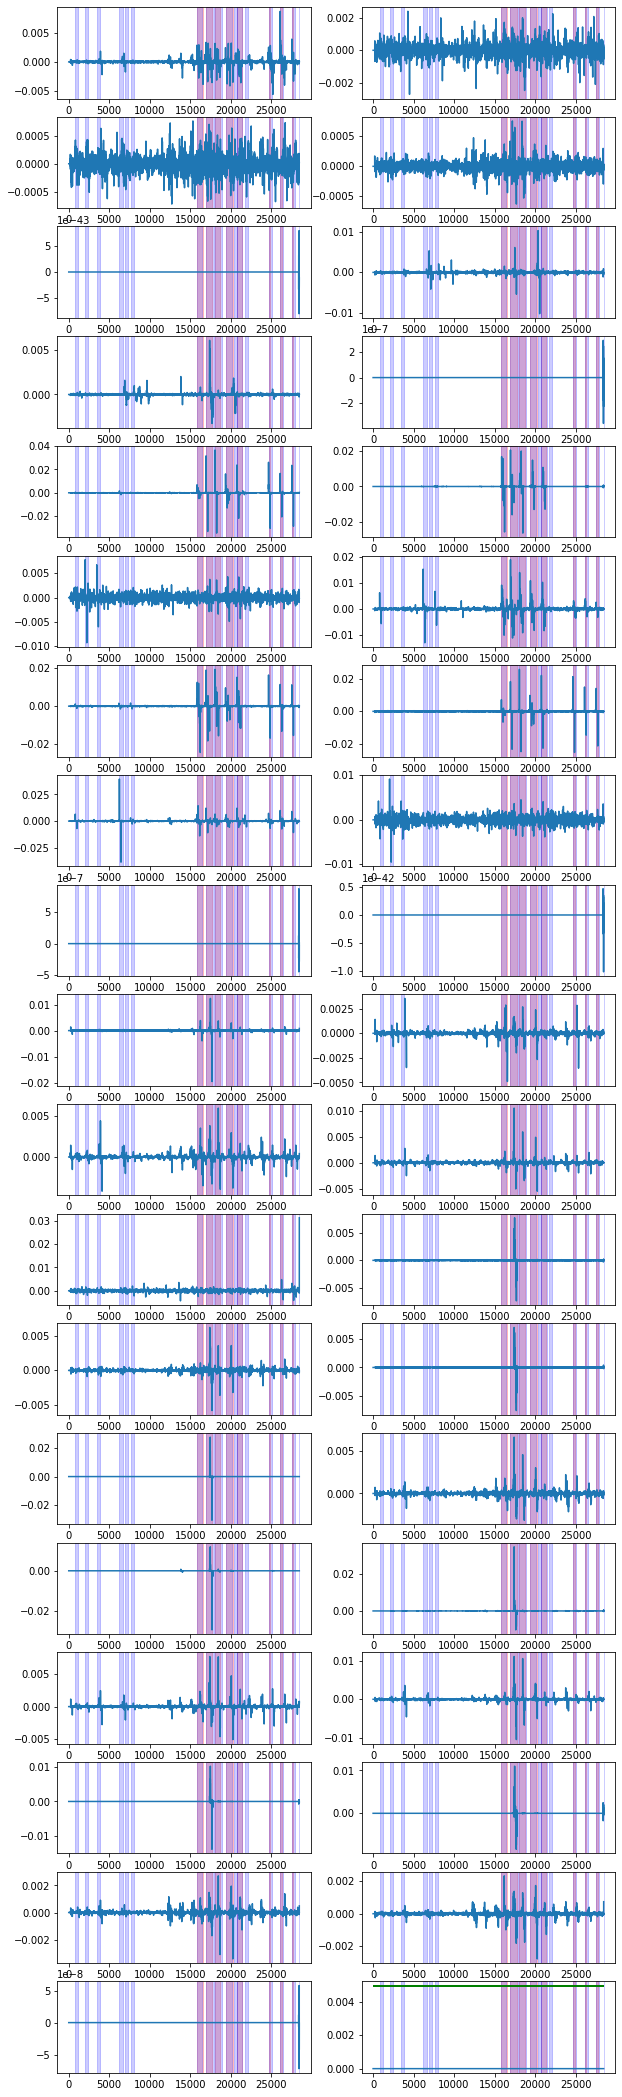

In [25]:
plot_dataset(
    ds={str(200): bounds[1]},
    anoms_vrects=get_cls_ids_ranges(test_index, test_cls),
    pred_anoms_vrects=get_cls_ids_ranges(test_index, std_th_df.loc[40, 'preds_rec_cls']),
    hlines={'std_200_th': std_th_df.loc[40, 'th']},
    # features_cols=[1, 8], figsize=(16, 8)
);

In [11]:
std_th_df.loc[std_th_df['ws'] == 500].sort_values('wdd', ascending=False).head()

ws      th         wdd  f0.5-score  f1-score     tn    fp    fn    tp  \
14  500  0.0075 -122.034244    0.894366  0.896470  17709  1000   927  8343   
15  500  0.0080 -122.035274    0.891428  0.890677  17710   999  1025  8245   
16  500  0.0085 -122.037776    0.889432  0.886829  17710   999  1089  8181   
7   500  0.0040 -131.189496    0.909965  0.935001  17632  1077   186  9084   
8   500  0.0045 -131.189496    0.909965  0.935001  17632  1077   186  9084   

                                        preds_rec_cls  
14  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
15  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
16  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
7   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [10]:
std_th_df.loc[std_th_df['ws'] == 500].sort_values('f1-score', ascending=False).head()

ws      th         wdd  f0.5-score  f1-score     tn    fp   fn    tp  \
7   500  0.0040 -131.189496    0.909965  0.935001  17632  1077  186  9084   
8   500  0.0045 -131.189496    0.909965  0.935001  17632  1077  186  9084   
9   500  0.0050 -131.192556    0.908743  0.932053  17637  1072  244  9026   
10  500  0.0055 -131.197703    0.902502  0.919613  17637  1072  467  8803   
13  500  0.0070 -131.220521    0.898598  0.911817  17638  1071  605  8665   

                                        preds_rec_cls  
7   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
8   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
9   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
10  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
13  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [13]:
th_df.loc[std_th_df['ws'] == 200].sort_values('f1-score', ascending=False).head()

Empty DataFrame
Columns: [ws, th, f0.5-score, f1-score, tn, fp, fn, tp, preds_rec_cls]
Index: []

In [45]:
std_th_df.loc[std_th_df.groupby(['ws'])['f0.5-score'].idxmax()]

ws      th         wdd  f0.5-score  f1-score     tn    fp   fn     tp  \
7     500  0.0040 -131.189496    0.909965  0.935001  17632  1077  186   9084   
106   600  0.0035 -156.614285    0.901441  0.929768  16732  1277  186   9684   
205   700  0.0030 -182.039073    0.894043  0.925195  15832  1477  186  10284   
305   800  0.0030 -207.723972    0.884931  0.919253  15265  1670  185  10559   
404   900  0.0025 -233.467914    0.875285  0.912824  14765  1870  185  10759   
504  1000  0.0025 -259.211856    0.866187  0.906714  14265  2070  185  10959   

                                         preds_rec_cls  
7    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
106  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
205  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
305  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
404  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...  
504  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

# Fitting Gaussian distribution

In [79]:
from scipy.stats import norm

mean_ = x_hat1_err_points_st.mean(axis=0)
std_ = x_hat1_err_points_st.var(axis=0)

train_scores = []
test_scores = []
for i, (m, s) in enumerate(zip(mean_, std_)):
    train_scores += [1 - norm(m, s).cdf(x_hat1_err_points_st[:, i])]
    test_scores += [1 - norm(m, s).cdf(x_hat1_err_points[:, i])]

train_scores = np.stack(train_scores, axis=1)
test_scores = np.stack(test_scores, axis=1)

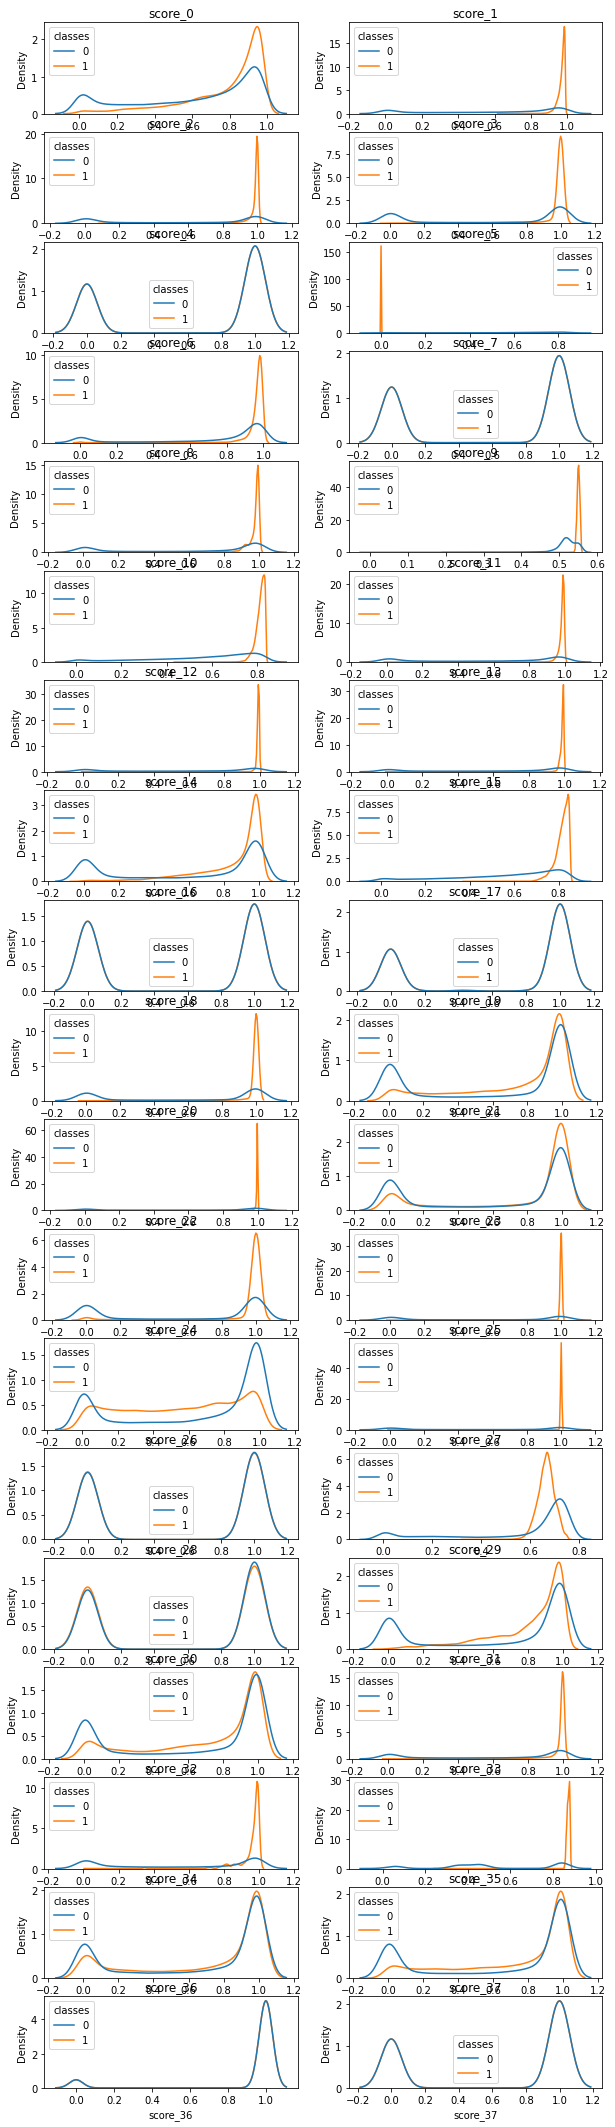

In [80]:
plot_kde(train_scores, scores2=test_scores);

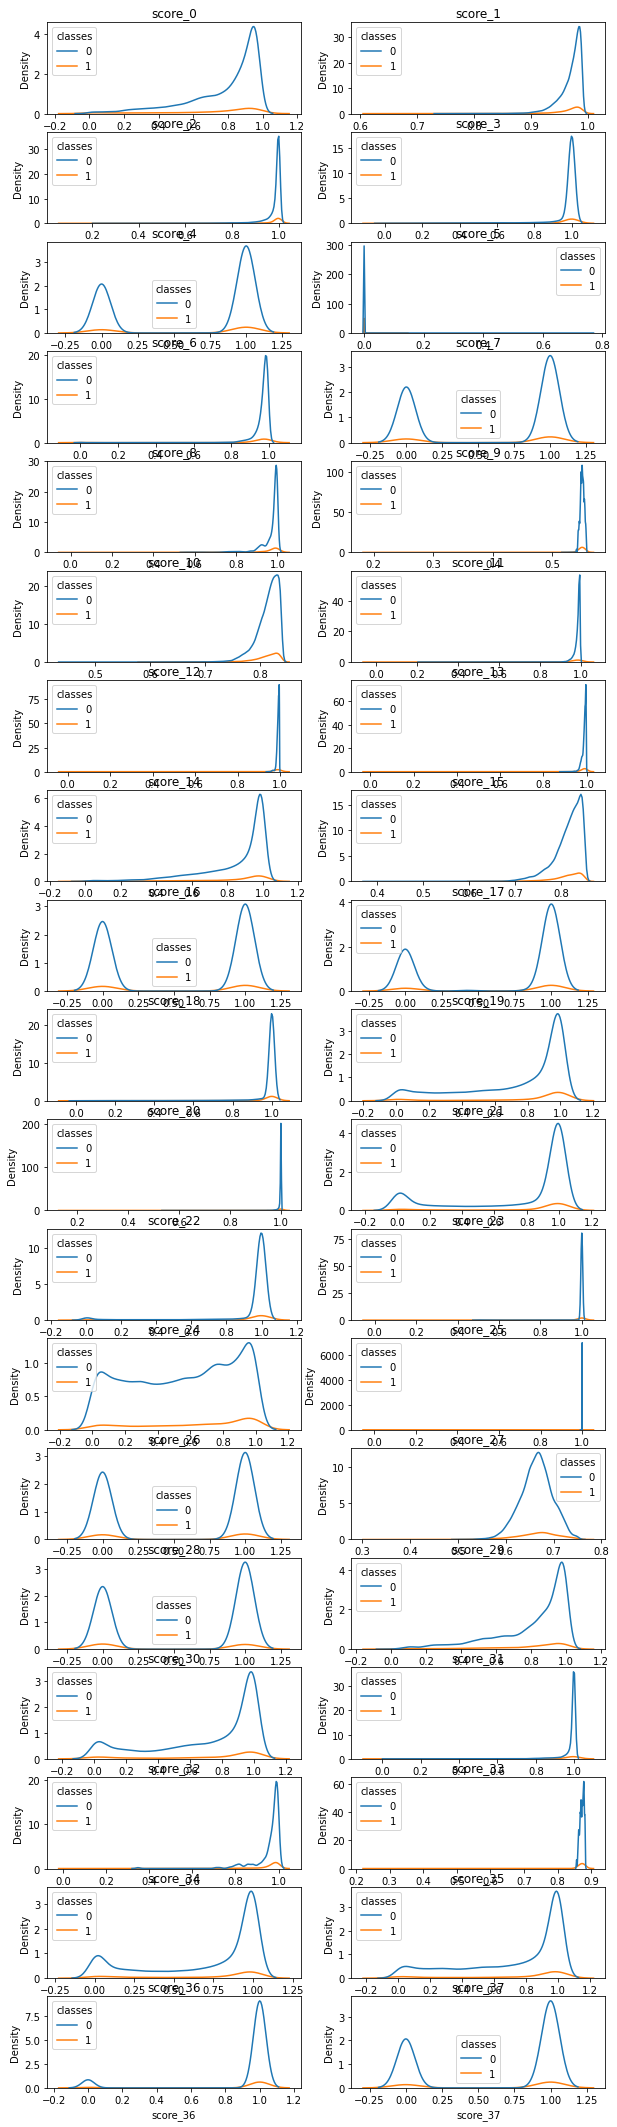

In [82]:
p_ids = np.argwhere(np.array(test_point_cls[1:]) == 1).reshape(-1)
n_ids = np.argwhere(np.array(test_point_cls[1:]) == 0).reshape(-1)
plot_kde(test_scores[n_ids], scores2=test_scores[p_ids]);